In [1]:
import warnings
warnings.filterwarnings("ignore")

ZERONLG_HOME = 'data/checkpoints'
SAVE_PATH = './examples'

In [2]:
import os
REPO = os.path.dirname(os.path.realpath('.'))
os.chdir(REPO)
os.environ['ZERONLG_HOME'] = ZERONLG_HOME
os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
from zeronlg import ZeroNLG
model = ZeroNLG('output/zeronlg-4langs-vc')

2023-11-17 16:05:44 - Load pretrained SentenceTransformer: output/zeronlg-4langs-vc
Framework(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity', 'proj_token_embs': False})
  (3): Projector({'in_features': 512, 'out_features': 768, 'bias': True, 'noise_std': 0.1, 'dropout': 0.1, 'noise_prob': 0, 'student_emb_keyname': 'sentence_embedding', 'teacher_emb_keyname': 'source_embedding'})
  (4): Decoder({'max_seq_length': 128, 'do_lower_case': False, 'attend_to': ['student'], 'teacher_model_name': 'clip-ViT-B-32', 'use_clip_tokens': False, 'language_identifier_strategy': 'bos'}) with Transformer model: BertLMHeadMode

In [ ]:
base_model = ZeroNLG('output/CapDec')

2023-11-17 16:05:51 - Load pretrained SentenceTransformer: output/CapDec
Framework(
  (0): Projector({'in_features': 512, 'out_features': 768, 'bias': True, 'noise_std': 0.12649110640673517, 'dropout': 0.1, 'noise_prob': 0, 'student_emb_keyname': 'sentence_embedding', 'teacher_emb_keyname': 'source_embedding'})
  (1): Decoder({'max_seq_length': 128, 'do_lower_case': False, 'attend_to': ['teacher'], 'teacher_model_name': 'clip-ViT-B-32', 'use_clip_tokens': False, 'language_identifier_strategy': 'bos'}) with Transformer model: BertLMHeadModel 
)
2023-11-17 16:05:54 - Load pretrained SentenceTransformer: clip-ViT-B-32


In [ ]:
import configs
from zeronlg import CaptionDataset

dataset_name = 'flickr30k'
lang = 'en'
mode = 'test'
dataset = CaptionDataset(
    vision_root=configs.image_video_root[dataset_name],
    ann_rpath=f'{configs.annotation_root}/{dataset_name}/{lang}/{mode}.json',
    lang=lang,
    clip_model=model.clip_model,
    return_images=True
)

2023-11-17 16:05:58 - CLIP embs does not exist: None


In [ ]:
len(dataset)

1000

In [ ]:
dataset.__getitem__(0).keys()

dict_keys(['image_id', 'text', 'emb', 'images', 'lang'])

In [ ]:
import configs
import matplotlib.pyplot as plt
import torch

def run(dataset, idx=None, image_id=None, langs=['en', 'zh', 'de', 'fr'], num_beams=3, mean_pooling=False):
    if image_id:
        item = dataset.get_item(image_id)
    else:
        assert idx is not None
        item = dataset.__getitem__(idx)
    
    assert item is not None
    print('Ground Truth:', item['text'])

    print('ZeroNLG outputs:')
    for lang in langs:
        evaluation_settings = {'num_beams': num_beams}
        evaluation_settings.update(configs.auto_settings[lang])

        embs = torch.FloatTensor(item['emb']).unsqueeze(0)
        if mean_pooling:
            embs = embs.mean(1, keepdims=True)
        
        caption = model.forward_caption(
            image_embs=embs,
            lang = lang,
            **evaluation_settings,
        )
        print(lang, caption)
    
    print('CapDec outputs:', base_model.forward_caption(
        image_embs=embs,
        lang = 'en',
        **evaluation_settings,
    ))

    plt.imshow(item['images'][0])
    plt.show()

Ground Truth: ['A man sits on a bench holding his dog and looking at the water.', 'A man holding a dog sitting on a bench overlooking a lake.', 'A man and a dog sit on a bench near a body of water.', 'A man and his dog watch the sunset from a bench.', 'A man holds his dog near a pond.']
ZeroNLG outputs:
en ['a man and a dog sitting on a bench at sunset']
zh ['一 个 男 人 和 他 的 狗 坐 在 长 椅 上 的 肖 像']
de ['Ein Mann sitzt auf einem Stuhl und schaut in']
fr ['homme assis sur un banc et regardant le coucher du soleil']
CapDec outputs: ['silhouette of a man sitting on the bench at sunset']


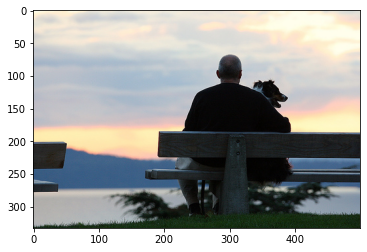

In [ ]:
image_id = 1489286545
run(dataset, image_id=image_id)
item = dataset.get_item(image_id)
item['images'][0].save(f'{SAVE_PATH}/{image_id}.png')

Ground Truth: ['A toddler boy in a sailor suit and a little girl run in the sand.', 'Two small children walk down a sandy beach.', 'Two kids run through gray sand.', 'Two young children are on sand.', 'Two smiling kids walking on sand']
ZeroNLG outputs:
en ['children running in the sand on the beach']
zh ['孩 子 们 在 沙 滩 上 奔 跑']
de ['Kinder, die am Strand spazieren gehen']
fr ['enfants heureux jouant sur la plage']
CapDec outputs: ['children playing on the beach']


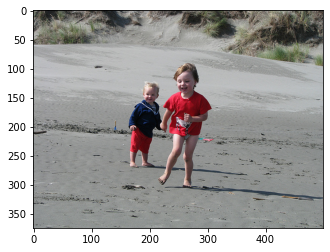

In [ ]:
image_id = 3278581900
run(dataset, image_id=image_id)
item = dataset.get_item(image_id)
item['images'][0].save(f'{SAVE_PATH}/{image_id}.png')

# Video

In [ ]:
dataset_name = 'msrvtt'
lang = 'en'
mode = 'test'
dataset = CaptionDataset(
    vision_root=configs.image_video_root[dataset_name],
    ann_rpath=f'{configs.annotation_root}/{dataset_name}/{lang}/{mode}.json',
    lang=lang,
    clip_model=model.clip_model,
    return_images=True,
)

2023-11-17 16:06:03 - CLIP embs does not exist: None


Ground Truth: ['a bride and groom dance and sing', 'a bride and groom dance at their wedding', 'a couple singing and enjoying their wedding', 'a man singing at a wedding', 'a marriage is going on', 'a newly wed couple enjoying a party', 'a singer performs at a wedding', 'a wedding couple at their reception', 'a wedding couple being filmed', 'a wedding party is shown with music and dancing', 'a woman in a wedding dress', 'people are at a wedding', 'people are dancing in celebration of a wedding', 'people are singing and dancing', 'the groom sings at a wedding', 'two people getting married and they are happy', 'video clip from ethiopian party celebration', 'the groom sings at a wedding', 'people are singing and dancing', 'people are singing and dancing']
ZeroNLG outputs:
en ['bride and groom kissing each other in a wedding dress']
zh ['新 娘 和 新 郎 在 婚 礼 上 跳 舞']
de ['Braut und Bräutigam tanzen während der Zeremonie']
fr ["l'acteur et sa femme assistent à la première pendant le festival"]
Ca

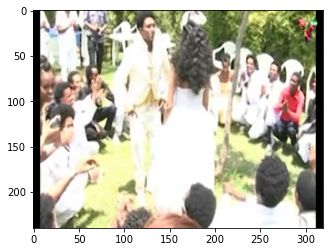

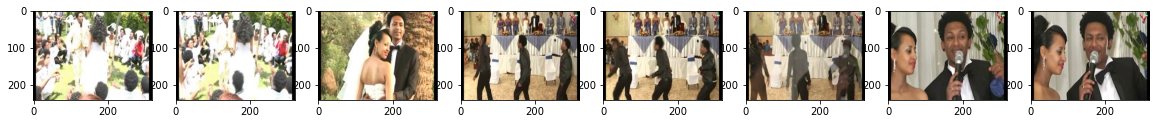

In [ ]:
image_id=8833
run(dataset, image_id=image_id)
item = dataset.get_item(image_id)
fig = plt.figure(figsize=(20,4))
for i in range(len(item['images'])):
    ax = plt.subplot(1, len(item['images']), i+1)
    ax.imshow(item['images'][i])

In [ ]:
for idx in [0, 2, 6, 7]:
    item['images'][idx].save(f'{SAVE_PATH}/{image_id}_{idx}.png')

Ground Truth: ['a woman speaking japanese and a woman dressed in a funny dress', 'a woman showing a dress on the  fasion show', 'there is a woman smiling with bridal costume', 'there is a woman talking about a new style of dressing', 'here the girl say that she wore a pink dress and she like very much and she describe about the pink colour', 'the girl supposed to be like the pink colored dress and she chooses and makes a conversation on the pink colour', 'a little girl with amazingly beautiful costume with flower works', 'there is a person dressed like a china doll in a pink frilly dress and bonnet', 'a japanese girl describes why she chose a pink lolita style dress', 'toy dressed in bridal wear', 'a girl in a pink dress and bonnet is shown', 'a pink outfit is shown while a woman talks about the outfit', 'brunette woman in pink clothes is being photographed', 'the small girl is looking perfect in pink clothes', 'woman is dressed in pink dress and she looks perfect', 'a woman in brown h

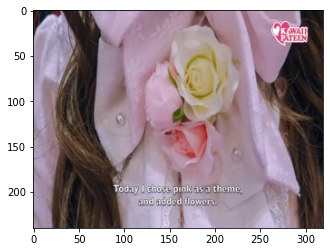

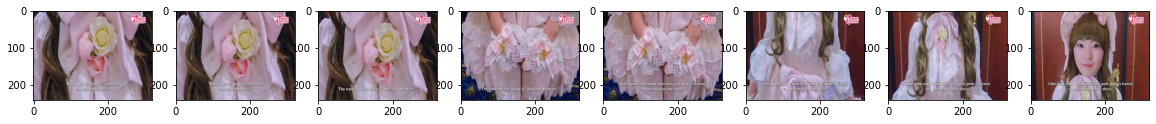

In [ ]:
image_id=9488
run(dataset, image_id=image_id)
item = dataset.get_item(image_id)
fig = plt.figure(figsize=(20,4))
for i in range(len(item['images'])):
    ax = plt.subplot(1, len(item['images']), i+1)
    ax.imshow(item['images'][i])

In [ ]:
for idx in [0, 3, 5, 6, 7]:
    item['images'][idx].save(f'{SAVE_PATH}/{image_id}_{idx}.png')